In [1]:
import os
import pandas as pd
from sqlalchemy import create_engine

# путь к БД на вашем компьютере (например, в той же папке, что и тетрадь)
path_to_db_local = 'telecomm_csi.db'
# путь к БД на платформе
path_to_db_platform = '/datasets/telecomm_csi.db'
# итоговый путь к БД
path_to_db = None

# если путь на вашем компьютере ведёт к БД, то он становится итоговым
if os.path.exists(path_to_db_local):
    path_to_db = path_to_db_local
# иначе: если путь на платформе ведёт к БД, то он становится итоговым
elif os.path.exists(path_to_db_platform):
    path_to_db = path_to_db_platform
# иначе выводится сообщение о том, что файл не найден
else:
    raise Exception('Файл с базой данных SQLite не найден!')

# если итоговый путь не пустой
if path_to_db:
    # то создаём подключение к базе
    engine = create_engine(f'sqlite:///{path_to_db}', echo=False)
    
    # пример запроса
    query = """
    SELECT u.user_id,
    u.lt_day,
    CASE 
           WHEN u.lt_day <= 365 THEN 'новый'
           WHEN u.lt_day > 365 THEN 'старый' 
       END AS is_new,
    u.age,
    CASE 
           WHEN u.gender_segment = 1.0 THEN 'женщина'
           WHEN u.gender_segment = 0.0 THEN 'мужчина'
       END AS gender_segment,
    u.os_name,
    u.cpe_type_name,
    l.country,
    l.city,
    SUBSTRING(a.title,4) AS age_segment,
    SUBSTRING(t.title,4) AS traffic_segment, 
    SUBSTRING(l.title,4) AS lifetime_segment,
    u.nps_score,
    CASE 
           WHEN u.nps_score <= 6 THEN 'критики'
           WHEN u.nps_score >= 9 THEN 'сторонники' 
           ELSE 'нейтралы'
       END AS nps_group
    FROM user AS u
    LEFT JOIN location AS l ON u.location_id = l.location_id
    LEFT JOIN age_segment AS a ON u.age_gr_id = a.age_gr_id
    LEFT JOIN traffic_segment AS t ON u.tr_gr_id = t.tr_gr_id
    LEFT JOIN lifetime_segment AS l ON u.lt_gr_id = l.lt_gr_id;
    """
    
    # создаём датафрейм по данным запроса
    df = pd.read_sql(query, engine)

In [2]:
df.head(3)

,user_id,lt_day,is_new,age,gender_segment,os_name,cpe_type_name,country,city,age_segment,traffic_segment,lifetime_segment,nps_score,nps_group
0,A001A2,2320,старый,45.0,женщина,ANDROID,SMARTPHONE,Россия,Уфа,45-54,1-5,36+,10,сторонники
1,A001WF,2344,старый,53.0,мужчина,ANDROID,SMARTPHONE,Россия,Киров,45-54,1-5,36+,10,сторонники
2,A003Q7,467,старый,57.0,мужчина,ANDROID,SMARTPHONE,Россия,Москва,55-64,20-25,13-24,10,сторонники


In [3]:
df.to_csv('telecomm_csi_tableau.csv', index=False)

### Дашборд ###

https://public.tableau.com/app/profile/alexey3476/viz/NPS_16764700610680/Dashboard1

lifetime_segment                   1     13-24         2     25-36         3  \
gender_segment age_segment                                                     
женщина        16-24             NaN  0.087361  0.245045  0.019798  0.236111   
               25-34        1.000000  0.214059  0.316308  0.145153  0.359766   
               35-44        0.333333  0.332435  0.450846  0.277917  0.431775   
               45-54        1.000000  0.438341  0.516770  0.360275  0.584877   
               55-64             NaN  0.518766  0.644828  0.475520  0.555066   
               66 +              NaN  0.565394  0.540000  0.559633  0.531915   
               n/a          1.000000  0.500000       NaN -0.333333       NaN   
               до 16             NaN  0.017857  0.500000  0.076923  0.111111   
мужчина        16-24             NaN  0.059398  0.182390 -0.030520  0.211240   
               25-34        0.000000  0.153785  0.285943  0.087561  0.291468   
               35-44        0.333333  0.308812  0.371588  0.217884  0.400000   
               45-54        1.000000  0.376032  0.536913  0.311503  0.493590   
               55-64        1.000000  0.427167  0.393548  0.392430  0.540146   
               66 +              NaN  0.473451  0.673913  0.387205  0.696970   
               n/a          0.000000 -0.333333 -1.000000 -1.000000       NaN   
               до 16             NaN  0.041096  0.000000 -0.092308  0.357143   

lifetime_segment                 36+       4-6      7-12  
gender_segment age_segment                                
женщина        16-24       -0.065762  0.271100  0.164977  
               25-34        0.027744  0.319668  0.291300  
               35-44        0.175038  0.449479  0.390759  
               45-54        0.300104  0.546698  0.484736  
               55-64        0.417602  0.584660  0.583396  
               66 +         0.536269  0.537143  0.640898  
               n/a         -0.285714       NaN  1.000000  
               до 16       -0.106383  0.222222  0.200000  
мужчина        16-24       -0.104258  0.205832  0.186634  
               25-34       -0.042019  0.274569  0.237321  
               35-44        0.100904  0.375661  0.368573  
               45-54        0.223342  0.417763  0.448566  
               55-64        0.334850  0.572482  0.469546  
               66 +         0.437282  0.573913  0.544444  
               n/a         -0.538462 -0.500000 -1.000000  
               до 16       -0.286765  0.058824  0.000000

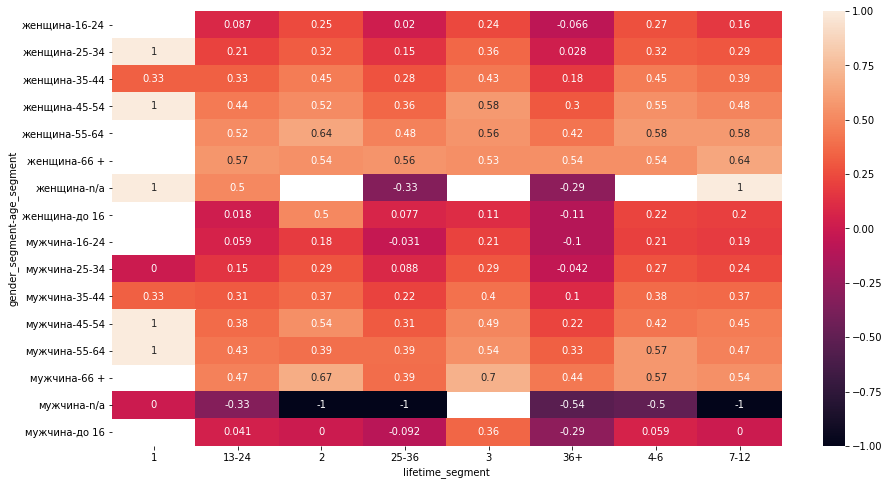

In [4]:
# Код ревьюера
import seaborn as sns
import matplotlib.pyplot as plt
d = df.assign(total_nps=lambda row: row['nps_group'].map({'сторонники': 1, 'нейтралы': 0, 'критики': -1}))\
  .pivot_table(index=['gender_segment', 'age_segment'], columns=['lifetime_segment'], values='total_nps', aggfunc='mean')
display(d)
plt.figure(figsize=(15,8))
sns.heatmap(d, annot=True);

### Презентация ##

https://disk.yandex.ru/i/XUMk0EPq2GcY9w